In [1]:
import findspark

In [2]:
findspark.init()

In [3]:
import pyspark
import numpy as np

In [4]:
conf = pyspark.SparkConf().\
    setAppName('sentiment-analysis').\
    setMaster('local[*]')

In [5]:
from pyspark.sql import SQLContext, HiveContext
sc = pyspark.SparkContext(conf=conf)
sqlContext = HiveContext(sc)

In [6]:
# dataframe functions
from pyspark.sql import functions as fn


In [7]:
# Create a RDDs
# We can create a dataframe from a RDD using the sqlContext.
documents_rdd = sc.parallelize([
         [1, 'cats are cute', 0],
        [2, 'dogs are playfull', 0],
        [3, 'lions are big', 1],
        [4, 'cars are fast', 1]])
users_rdd = sc.parallelize([
        [0, 'Alice', 20],
        [1, 'Bob', 23],
        [2, 'Charles', 32]])

In [8]:
# From the previous RDDs, we can call the toDF method and specify the name of columns:
documents_df = documents_rdd.toDF(['doc_id', 'text', 'user_id'])
users_df = users_rdd.toDF(['user_id', 'name', 'age'])

In [9]:
# Spark will automatically try to guess the column types. We can take a look at those types:
documents_df.printSchema()

root
 |-- doc_id: long (nullable = true)
 |-- text: string (nullable = true)
 |-- user_id: long (nullable = true)



In [10]:
users_df.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- age: long (nullable = true)



In [11]:
# Similar to SQL, we can apply a function to a column or several columns.
from pyspark.sql import functions as fn

In [12]:
# compute the average age of users
user_age_df = users_df.select(fn.avg('age'))
user_age_df

DataFrame[avg(age): double]

In [13]:
# As you can see, the function is not evaluated until an action (e.g., take, show, collect) is taken
user_age_df.show()

+--------+
|avg(age)|
+--------+
|    25.0|
+--------+



In [14]:
# We can cross (e.g., join) two dataframes ala SQL.
users_df.join(documents_df, on='user_id').show()

+-------+-----+---+------+-----------------+
|user_id| name|age|doc_id|             text|
+-------+-----+---+------+-----------------+
|      0|Alice| 20|     1|    cats are cute|
|      0|Alice| 20|     2|dogs are playfull|
|      1|  Bob| 23|     3|    lions are big|
|      1|  Bob| 23|     4|    cars are fast|
+-------+-----+---+------+-----------------+



In [15]:
# We can also do outer joins
users_df.join(documents_df, on='user_id', how='left').show()

+-------+-------+---+------+-----------------+
|user_id|   name|age|doc_id|             text|
+-------+-------+---+------+-----------------+
|      0|  Alice| 20|     1|    cats are cute|
|      0|  Alice| 20|     2|dogs are playfull|
|      1|    Bob| 23|     3|    lions are big|
|      1|    Bob| 23|     4|    cars are fast|
|      2|Charles| 32|  null|             null|
+-------+-------+---+------+-----------------+



In [16]:
# We can apply group functions.
users_df.join(documents_df, 'user_id', how='left').\
    groupby('user_id', 'name').\
    agg(fn.count('text')).\
    show()

+-------+-------+-----------+
|user_id|   name|count(text)|
+-------+-------+-----------+
|      0|  Alice|          2|
|      1|    Bob|          2|
|      2|Charles|          0|
+-------+-------+-----------+



In [17]:
# We can change the name of computed columns:
users_df.join(documents_df, 'user_id', how='left').\
    groupby('user_id', 'name').\
    agg(fn.count('text').alias('n_pets')).\
    show()

+-------+-------+------+
|user_id|   name|n_pets|
+-------+-------+------+
|      0|  Alice|     2|
|      1|    Bob|     2|
|      2|Charles|     0|
+-------+-------+------+



In [18]:
# Add columns:
users_df.withColumn('name_length', fn.length('name')).show()

+-------+-------+---+-----------+
|user_id|   name|age|name_length|
+-------+-------+---+-----------+
|      0|  Alice| 20|          5|
|      1|    Bob| 23|          3|
|      2|Charles| 32|          7|
+-------+-------+---+-----------+



Transformers and Estimators
There are several ways of transforming the data from raw input to something that can be analyzed with a statistical model.

Some examples of such transformers are displayed below:

Tokenizer
Suppose that we want to split the words or tokens of a document. This is what Tokenizer does.

In [19]:
from pyspark.ml.feature import Tokenizer

Almost all transfomers and estimator require you to specifiy the input column of the dataframe and the output column that will be added to the dataframe.

In [20]:
# the tokenizer object
tokenizer = Tokenizer().setInputCol('text').setOutputCol('words')

In [21]:
# We can now transform the dataframe
tokenizer.transform(documents_df).show()

+------+-----------------+-------+--------------------+
|doc_id|             text|user_id|               words|
+------+-----------------+-------+--------------------+
|     1|    cats are cute|      0|   [cats, are, cute]|
|     2|dogs are playfull|      0|[dogs, are, playf...|
|     3|    lions are big|      1|   [lions, are, big]|
|     4|    cars are fast|      1|   [cars, are, fast]|
+------+-----------------+-------+--------------------+



CountVectorizer
This transformer counts how many times a word appears in a list and produces a vector with such counts. This is very useful for text analysis.

In [22]:
from pyspark.ml.feature import CountVectorizer

A CountVectorizer is different from a Tokenizer because it needs to learn how many different tokens there are in the input column. With that number, it will output vectors with consistent dimensions. Therefore, CountVectorizer is an Estimator that, when fitted, returns a Transformer.

In [23]:
count_vectorizer_estimator = CountVectorizer().setInputCol('words').setOutputCol('features')

In [24]:
#Now we need to user the words column that generated by the tokenizer transformer.
count_vectorizer_transformer = count_vectorizer_estimator.fit(tokenizer.transform(documents_df))

In [25]:
#which results in:
count_vectorizer_transformer.transform(tokenizer.transform(documents_df)).show(truncate=False)

+------+-----------------+-------+---------------------+-------------------------+
|doc_id|text             |user_id|words                |features                 |
+------+-----------------+-------+---------------------+-------------------------+
|1     |cats are cute    |0      |[cats, are, cute]    |(9,[0,4,7],[1.0,1.0,1.0])|
|2     |dogs are playfull|0      |[dogs, are, playfull]|(9,[0,5,6],[1.0,1.0,1.0])|
|3     |lions are big    |1      |[lions, are, big]    |(9,[0,1,2],[1.0,1.0,1.0])|
|4     |cars are fast    |1      |[cars, are, fast]    |(9,[0,3,8],[1.0,1.0,1.0])|
+------+-----------------+-------+---------------------+-------------------------+



The column features is a sparse vector representation. For example, for the first document, we have three features present: 0, 3, and 5. By looking at the vocabulary learned by count_vectorizer_transformer, we can know which words those feature indices refer to:

In [26]:
# list of words in the vocabulary
count_vectorizer_transformer.vocabulary

['are', 'big', 'lions', 'cars', 'cats', 'dogs', 'playfull', 'cute', 'fast']

In [27]:
np.array(count_vectorizer_transformer.vocabulary)[[0, 3, 5]]

array(['are', 'cars', 'dogs'], dtype='<U8')

Pipelines

Sometimes, we have long preprocessing steps that take raw data and transform it through several stages. As explained before, these complex transformations can be captured by Pipelines.

Pipelines are always estimators, even when they contain several transformers. After a pipeline is fit to the data, the pipeline becomes an transformer.

We will now define a pipeline that takes the raw text column and produces the features column previously explained

In [28]:
from pyspark.ml import Pipeline

In [29]:
pipeline_cv_estimator = Pipeline(stages=[tokenizer, count_vectorizer_estimator])

In [30]:
pipeline_cv_transformer = pipeline_cv_estimator.fit(documents_df)

In [31]:
pipeline_cv_transformer.transform(documents_df).show()

+------+-----------------+-------+--------------------+--------------------+
|doc_id|             text|user_id|               words|            features|
+------+-----------------+-------+--------------------+--------------------+
|     1|    cats are cute|      0|   [cats, are, cute]|(9,[0,4,8],[1.0,1...|
|     2|dogs are playfull|      0|[dogs, are, playf...|(9,[0,2,7],[1.0,1...|
|     3|    lions are big|      1|   [lions, are, big]|(9,[0,1,3],[1.0,1...|
|     4|    cars are fast|      1|   [cars, are, fast]|(9,[0,5,6],[1.0,1...|
+------+-----------------+-------+--------------------+--------------------+



In more complex scenarios, you can even chain Pipeline transformers. We will see this case in the actual use case below.

# Download the review, sentiment, and tweet datasets

In [32]:
sentiments_df = sqlContext.read.parquet('sentiments.parquet')

In [33]:
sentiments_df.printSchema()

root
 |-- word: string (nullable = true)
 |-- sentiment: long (nullable = true)



The schema is very simple: for each word, we have whether it is positive (+1) or negative (-1)

In [34]:
# a sample of positive words
sentiments_df.where(fn.col('sentiment') == 1).show(5)

+-------------+---------+
|         word|sentiment|
+-------------+---------+
|   gratefully|        1|
|gratification|        1|
|    gratified|        1|
|    gratifies|        1|
|      gratify|        1|
+-------------+---------+
only showing top 5 rows



In [35]:
# a sample of negative words
sentiments_df.where(fn.col('sentiment') == -1).show(5)

+----------+---------+
|      word|sentiment|
+----------+---------+
|   2-faced|       -1|
|   2-faces|       -1|
|  abnormal|       -1|
|   abolish|       -1|
|abominable|       -1|
+----------+---------+
only showing top 5 rows



In [36]:
# Let's see how many of each category we have
sentiments_df.groupBy('sentiment').agg(fn.count('*')).show()

+---------+--------+
|sentiment|count(1)|
+---------+--------+
|        1|    2006|
|       -1|    4783|
+---------+--------+



In [37]:
# We have almost two times the number of negative words!

# A simple approach to sentiment analysis

One simple approach for sentiment analysis is to simple count the number of positive and negative words in a text and then compute the average sentiment. Assuming that positive words are +1 and negative words are -1, we can classify a text as positive if the average sentiment is greater than zero and negative otherwise

To test our approach, we will use a sample of IMDB reviews that were tagged as positive and negative.

Let’s load them:

In [38]:
imdb_reviews_df = sqlContext.read.parquet('imdb_reviews_preprocessed.parquet')

In [39]:
imdb_reviews_df.where(fn.col('score') == 1).first()

Row(id='pos_10006', review='In this "critically acclaimed psychological thriller based on true events, Gabriel (Robin Williams), a celebrated writer and late-night talk show host, becomes captivated by the harrowing story of a young listener and his adoptive mother (Toni Collette). When troubling questions arise about this boy\'s (story), however, Gabriel finds himself drawn into a widening mystery that hides a deadly secret\x85" according to film\'s official synopsis.<br /><br />You really should STOP reading these comments, and watch the film NOW...<br /><br />The "How did he lose his leg?" ending, with Ms. Collette planning her new life, should be chopped off, and sent to "deleted scenes" land. It\'s overkill. The true nature of her physical and mental ailments should be obvious, by the time Mr. Williams returns to New York. Possibly, her blindness could be in question - but a revelation could have be made certain in either the "highway" or "video tape" scenes. The film would benefi

In [40]:
# And a negative one:
imdb_reviews_df.where(fn.col('score') == 0).first()

Row(id='neg_10006', review="I don't know who to blame, the timid writers or the clueless director. It seemed to be one of those movies where so much was paid to the stars (Angie, Charlie, Denise, Rosanna and Jon) that there wasn't enough left to really make a movie. This could have been very entertaining, but there was a veil of timidity, even cowardice, that hung over each scene. Since it got an R rating anyway why was the ubiquitous bubble bath scene shot with a 70-year-old woman and not Angie Harmon? Why does Sheen sleepwalk through potentially hot relationships WITH TWO OF THE MOST BEAUTIFUL AND SEXY ACTRESSES in the world? If they were only looking for laughs why not cast Whoopi Goldberg and Judy Tenuta instead? This was so predictable I was surprised to find that the director wasn't a five year old. What a waste, not just for the viewers but for the actors as well.", score=0.0)

The first problem that we encounter is that the reviews are in plain text. We need to split the words and then match them to sentiment_df.

To do, we will use a transformation that takes raw text and outputs a list of words

In [41]:
from pyspark.ml.feature import RegexTokenizer

RegexTokenizer extracts a sequence of matches from the input text. Regular expressions are a powerful tool to extract strings with certain characteristics.

In [42]:
tokenizer = RegexTokenizer().setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("review")\
  .setOutputCol("words")

The pattern \p{L}+ means that it will extract letters without accents (e.g., it will extract “Acuna” from “Acuña”). setGaps means that it will keep applying the rule until it can’t extract new words. You have to set the input column from the incoming dataframe (in our case the review column) and the new column that will be added (e.g., words).

We are ready to transform the input dataframe imdb_reviews_df with the tokenizer:

In [43]:
review_words_df = tokenizer.transform(imdb_reviews_df)
print(review_words_df)

DataFrame[id: string, review: string, score: double, words: array<string>]


Applying the transformation doesn’t actually do anything until you apply an action. But as you can see, a new column words of type array of string was added by the transformation. We can see how it looks:

In [44]:
review_words_df.show(5)

+---------+--------------------+-----+--------------------+
|       id|              review|score|               words|
+---------+--------------------+-----+--------------------+
|pos_10006|In this "critical...|  1.0|[in, this, critic...|
|pos_10013|Like one of the p...|  1.0|[like, one, of, t...|
|pos_10022|Aro Tolbukhin bur...|  1.0|[aro, tolbukhin, ...|
|pos_10033|The movie Titanic...|  1.0|[the, movie, tita...|
| pos_1003|Another Aussie ma...|  1.0|[another, aussie,...|
+---------+--------------------+-----+--------------------+
only showing top 5 rows



Now, we want to match every word from sentiment_df in the array words shown before. One way of doing this is to explode the column words to create a row for each element in that list. Then, we would join that result with the dataframe sentiment to continue further.

In [45]:
review_words_df.select('id', fn.explode('words').alias('word')).show(5)

+---------+-------------+
|       id|         word|
+---------+-------------+
|pos_10006|           in|
|pos_10006|         this|
|pos_10006|   critically|
|pos_10006|    acclaimed|
|pos_10006|psychological|
+---------+-------------+
only showing top 5 rows



Now if we join that with sentiment, we can see if there are positive and negative words in each review:

In [46]:
review_word_sentiment_df = review_words_df.\
    select('id', fn.explode('words').alias('word')).\
    join(sentiments_df, 'word')
review_word_sentiment_df.show(5)

+----------+---------+---------+
|      word|       id|sentiment|
+----------+---------+---------+
| acclaimed|pos_10006|        1|
|celebrated|pos_10006|        1|
| troubling|pos_10006|       -1|
|   mystery|pos_10006|       -1|
|    deadly|pos_10006|       -1|
+----------+---------+---------+
only showing top 5 rows



Now we can simply average the sentiment per review id and, say, pick positive when the average is above 0, and negative otherwise.

In [47]:
simple_sentiment_prediction_df = review_word_sentiment_df.\
    groupBy('id').\
    agg(fn.avg('sentiment').alias('avg_sentiment')).\
    withColumn('predicted', fn.when(fn.col('avg_sentiment') > 0, 1.0).otherwise(0.))
simple_sentiment_prediction_df.show(5)

+---------+--------------------+---------+
|       id|       avg_sentiment|predicted|
+---------+--------------------+---------+
|pos_10149| 0.42857142857142855|      1.0|
|pos_10377|  0.5384615384615384|      1.0|
| pos_1299| 0.09090909090909091|      1.0|
| pos_2228|-0.14285714285714285|      0.0|
| pos_5052|  0.7777777777777778|      1.0|
+---------+--------------------+---------+
only showing top 5 rows



In [48]:
#Now, lets compute the accuracy of our prediction

imdb_reviews_df.\
    join(simple_sentiment_prediction_df, 'id').\
    select(fn.expr('float(score = predicted)').alias('correct')).\
    select(fn.avg('correct')).\
    show()

+-----------------+
|     avg(correct)|
+-----------------+
|0.732231471106131|
+-----------------+



# Not bad with such a simple approach! But can we do better than this?                                            A data-driven sentiment prediction

There are couple of problems with the previous approach: 1. Positive and negative words had the same weight (e.g., good == amazing) 1. Maybe a couple of negative words make the entire review negative, whereas positive words do not 1. While our dataset is artificially balanced (12500 positive and 12500 negative), there are usually more positive than negative reviews, and therefore we should bias our predictions towards positive ones.

We could use data to estimate the sentiment that each word is contributing to the final sentiment of a review. Given that we are trying to predict negative and positve reviews, then we can use logistic regression for such binary prediction.

From text to numerical features
One typical approach is to count how many times a word appears in the text and then perform a reweighting so that words that are very common are “counted” less.

In Spark, we can achieve this by using several transformers:

Raw text => Tokens => Remove stop words => Term Frequency => Reweighting by Inverse Document frequency

To perform this sequence we will create a Pipeline to consistently represent the steps from raw text to TF-IDF.

First, we need to create a sequence to take from raw text to term frequency. This is necessary because we don’t know the number of tokens in the text and therefore we need to estimate such quantity from the data.


In [49]:
# we obtain the stop words from a website
import requests
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
stop_words[0:10]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost']

In [50]:
from pyspark.ml.feature import StopWordsRemover
sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

Finally, for this initial Pipeline, we define a counter vectorizer estimator

In [51]:
from pyspark.ml.feature import CountVectorizer

# we will remove words that appear in 5 docs or less
cv = CountVectorizer(minTF=1., minDF=5., vocabSize=2**17)\
  .setInputCol("filtered")\
  .setOutputCol("tf")

In [52]:
# we now create a pipelined transformer
cv_pipeline = Pipeline(stages=[tokenizer, sw_filter, cv]).fit(imdb_reviews_df)

In [53]:
# now we can make the transformation between the raw text and the counts
cv_pipeline.transform(imdb_reviews_df).show(5)

+---------+--------------------+-----+--------------------+--------------------+--------------------+
|       id|              review|score|               words|            filtered|                  tf|
+---------+--------------------+-----+--------------------+--------------------+--------------------+
|pos_10006|In this "critical...|  1.0|[in, this, critic...|[critically, accl...|(26677,[0,1,3,4,5...|
|pos_10013|Like one of the p...|  1.0|[like, one, of, t...|[like, previous, ...|(26677,[1,2,3,4,5...|
|pos_10022|Aro Tolbukhin bur...|  1.0|[aro, tolbukhin, ...|[aro, tolbukhin, ...|(26677,[0,1,2,12,...|
|pos_10033|The movie Titanic...|  1.0|[the, movie, tita...|[movie, titanic, ...|(26677,[0,1,2,3,4...|
| pos_1003|Another Aussie ma...|  1.0|[another, aussie,...|[aussie, masterpi...|(26677,[4,5,9,24,...|
+---------+--------------------+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



The term frequency vector is represented with a sparse vector. We have 26,384 terms.

Finally, we build another pipeline that takes the output of the previous pipeline and lowers the terms of documents that are very common.

In [54]:
from pyspark.ml.feature import IDF
idf = IDF().\
    setInputCol('tf').\
    setOutputCol('tfidf')

In [55]:
idf_pipeline = Pipeline(stages=[cv_pipeline, idf]).fit(imdb_reviews_df)

In [56]:
idf_pipeline.transform(imdb_reviews_df).show(5)

+---------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|       id|              review|score|               words|            filtered|                  tf|               tfidf|
+---------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|pos_10006|In this "critical...|  1.0|[in, this, critic...|[critically, accl...|(26677,[0,1,3,4,5...|(26677,[0,1,3,4,5...|
|pos_10013|Like one of the p...|  1.0|[like, one, of, t...|[like, previous, ...|(26677,[1,2,3,4,5...|(26677,[1,2,3,4,5...|
|pos_10022|Aro Tolbukhin bur...|  1.0|[aro, tolbukhin, ...|[aro, tolbukhin, ...|(26677,[0,1,2,12,...|(26677,[0,1,2,12,...|
|pos_10033|The movie Titanic...|  1.0|[the, movie, tita...|[movie, titanic, ...|(26677,[0,1,2,3,4...|(26677,[0,1,2,3,4...|
| pos_1003|Another Aussie ma...|  1.0|[another, aussie,...|[aussie, masterpi...|(26677,[4,5,9,24,...|(26677,[4,5,9,24,...|
+---------+-----

Therefore, the idf_pipeline takes the raw text from the datafarme imdb_reviews_df and creates a feature vector vector called tfidf!

In [57]:
tfidf_df = idf_pipeline.transform(imdb_reviews_df)

# Data science pipeline for estimating sentiments

In [58]:
#First, let’s split the data into training, validation, and testing.
training_df, validation_df, testing_df = imdb_reviews_df.randomSplit([0.6, 0.3, 0.1], seed=0)

In [59]:
[training_df.count(), validation_df.count(), testing_df.count()]

[15081, 7350, 2569]

One immediately apparent problem is that the number of features in the dataset is far larger than the number of training examples. This can lead to serious overfitting.

Let’s look at this more closely. Let’s apply a simple prediction model known as logistic regression.

Logistic regression will take the tfidf features and predict whether the review is positive (score == 1) or negative (score == 0).

In [60]:
from pyspark.ml.classification import LogisticRegression

In [61]:
lr = LogisticRegression().\
    setLabelCol('score').\
    setFeaturesCol('tfidf').\
    setRegParam(0.0).\
    setMaxIter(100).\
    setElasticNetParam(0.)


In [62]:
#Lets create a pipeline transformation by chaining the idf_pipeline with the logistic regression step (lr)
lr_pipeline = Pipeline(stages=[idf_pipeline, lr]).fit(training_df)

In [63]:
#Lets estimate the accuracy:
lr_pipeline.transform(validation_df).\
    select(fn.expr('float(prediction = score)').alias('correct')).\
    select(fn.avg('correct')).show()

+------------------+
|      avg(correct)|
+------------------+
|0.8440816326530612|
+------------------+



The performance is much better than before.

The problem however is that we are overfitting because we have many features compared to the training examples:

For example, if we look at the weights of the features, there is a lot of noise:


In [64]:
import pandas as pd
vocabulary = idf_pipeline.stages[0].stages[-1].vocabulary
weights = lr_pipeline.stages[-1].coefficients.toArray()
coeffs_df = pd.DataFrame({'word': vocabulary, 'weight': weights})

In [65]:
#The most negative words are:
coeffs_df.sort_values('weight').head(5)

,word,weight
23995,albright,-6.010620
26664,dawning,-5.771948
25217,rallying,-3.854359
23854,disrobe,-3.828086
26053,prolong,-3.757287


In [66]:
#And the most positive:
coeffs_df.sort_values('weight', ascending=False).head(5)

,word,weight
20635,ingeniously,5.123669
22368,riffing,5.097224
25118,tweed,3.903306
22010,outlined,3.814566
24466,beastiality,3.813886


But none of them make sense. What is happening? We are overfitting the data. Those words that don’t make sense are capturing just noise in the reviews.

For example, the word "helming" appears in only one review:

In [67]:
idf_pipeline.transform(training_df).\
    select('id', fn.explode('words').alias('word')).\
    where(fn.col('word') == 'helming').\
    join(training_df, 'id').\
    first()

Row(id='pos_2548', word='helming', review='Karloff and Lugosi - Together again! This is one of those films that casual fans will pass over and tend not to appreciate as much. It\'s not an all-out horror film like the duo\'s previous two hits, The Black Cat and The Raven. But, it is very worthy of both\'s talents and is a fun film when re-visited.<br /><br />The Invisible Ray was directed by Lambert Hillyer, a director who mainly made westerns, but curiously in these final days of the Laemmles\' reign at Universal, he found himself helming this and the Laemmles\' final horror film, Dracula\'s Daughter. Both are crisp, clean-cut fantasies that are very light on horror content despite the fantastic elements.<br /><br />Just as Lugosi went wild in The Raven, much needs to be said of Karloff\'s hamming in The Invisible Ray. The one aspect of the story that is particularly unsatisfying is that Karloff\'s character, Rukh, acts so madly before he is poisoned by Radium X, that there really isn\

# Regularization

One way to prevent overfitting during training is to modify the loss function and penalize weight values that are too large.

There are two major regularization techniques, one based on penalizing the squared value of the weight (called L2 or ridge regularization) and anotherbased on penalizing the absolute value of the weight (called L1 or lasso regularization).

The unregularized logistic regression loss function is:

Lθ(p(X),Y)=−(∑iYipθ(Xi)+(1−Yi)(1−pθ(Xi)))
where $p_\theta(\cdot)$ is the sigmoid function:

pθ(X)=11+exp(−(θ0+∑j>0xjθj))
If we modify the loss function $L_\theta$ slightly

Lλθ(p(X),Y)=−(∑iYipθ(Xi)+(1−Yi)(1−pθ(Xi)))+λ∑j>0θ2j
we obtain what is known as L2 regularization.

Notice how we increase the loss function by $\lambda$ times the square of the weights. In practice, this means that we will think twice about increasing the importance of a feature. This loss function will prevent the algorithm for fitting certain data points, such as outliers or noise, unless the decrease in loss for the data grants it. Also, notice that the penalization doesn’t apply to the bias parameter $\theta_0$.

You can see more clearly the effect of such cost function when $\lambda$ goes to infinity: the features will not be used for predicting and only the bias term will matter! This prevents the algorithm from learning altogether, forcing it to underfit!

One problem with L2 regularization is that all weights go to zero uniformly. In a sense, all features will matter but less than with the unregularized loss function. This is a really strange because we do not want all features to matter. In sentiment analysis, we want to select certain features because we want to understand that only some words have effects on the sentiment.

A different modification of the original loss function can achieve this. This regularization is known as L1 or lasso reguarlization and penalizes the absolute value of the weight

Lλθ(p(X),Y)=−(∑iYipθ(Xi)+(1−Yi)(1−pθ(Xi)))+λ∑j>0∣∣θj∣∣
The practical effect of L1 regularization is that the difference between a feature having no importance vs some small importance is massively bigger than with L2 regularization. Therefore, optimizing the L1 loss function usually brings some features to have exactly zero weight.

One problem with L1 regularization is that it will never select more features that the number of examples. This is because it can always fit the training data perfectly when the number of features equals the number of examples. In our sentimental analysis, this is the case (there are more words than examples).

One way of remedying this is to have a combination of both L1 and L2. This is known as elastic net regularization. For this type of regularization, we have to pick a parameter ($\alpha$) deciding to consider L1 vs L2 regularization. If $\alpha=0$, then we choose L2, and if $\alpha=1$ we choose L1. For example, $\alpha=0.5$ means half L1 and half L2.

Lλ,αθ(p(X),Y)=−(∑iYipθ(Xi)+(1−Yi)(1−pθ(Xi)))+λ[(1−α)∑j>0θ2j+α∑j>0∣∣θj∣∣]
Unfortunately, elastic net regularization comes with two additional parameters, $\lambda$ and $\alpha$, and we must either select them a priori or used the validation set to choose the best one.



In [68]:
#Spark allows to fit elatic net regularization easily
lambda_par = 0.02
alpha_par = 0.3
en_lr = LogisticRegression().\
        setLabelCol('score').\
        setFeaturesCol('tfidf').\
        setRegParam(lambda_par).\
        setMaxIter(100).\
        setElasticNetParam(alpha_par)

In [69]:
#And we define a new Pipeline
en_lr_pipeline = Pipeline(stages=[idf_pipeline, en_lr]).fit(training_df)

In [70]:
#Let’s look at the performance
en_lr_pipeline.transform(validation_df).select(fn.avg(fn.expr('float(prediction = score)'))).show()

+--------------------------------+
|avg(float((prediction = score)))|
+--------------------------------+
|              0.8761904761904762|
+--------------------------------+



We improve performance slightly, but whats more important is that we improve the understanding of the word sentiments. Lets take at the weights:

In [71]:
en_weights = en_lr_pipeline.stages[-1].coefficients.toArray()
en_coeffs_df = pd.DataFrame({'word': vocabulary, 'weight': en_weights})

The most negative words all make sense (“worst” is actually more negative than than “worse”)!

In [72]:
en_coeffs_df.sort_values('weight').head(15)

,word,weight
103,worst,-0.385505
258,waste,-0.376117
201,awful,-0.244323
11,bad,-0.235669
1134,disappointment,-0.209448
754,fails,-0.195139
190,boring,-0.190572
627,poorly,-0.185320
174,poor,-0.177938
701,mess,-0.176395


In [73]:
#Same thing with positive words
en_coeffs_df.sort_values('weight', ascending=False).head(15)

,word,weight
13,great,0.270940
160,excellent,0.260410
216,wonderful,0.181065
2146,refreshing,0.175973
29,best,0.174953
320,favorite,0.159823
12415,batista,0.145553
1405,wonderfully,0.143651
23139,insides,0.136986
291,amazing,0.133872


In [74]:
#Are there words with literarily zero importance for predicting sentiment? Yes, and most of them!
en_coeffs_df.query('weight == 0.0').shape

(25573, 2)

In [75]:
#In fact, more than 95% of features are not needed to achieve a better performance than all previous models!
en_coeffs_df.query('weight == 0.0').shape[0]/en_coeffs_df.shape[0]

0.9586160362859392

In [76]:
#Let’s look at these neutral words
en_coeffs_df.query('weight == 0.0').head(15)

,word,weight
0,br,0.0
3,film,0.0
5,like,0.0
9,story,0.0
10,really,0.0
12,people,0.0
14,don,0.0
15,way,0.0
17,movies,0.0
19,characters,0.0


But, did we choose the right $\lambda$ and $\alpha$ parameters? We should run an experiment where we try different combinations of them. Fortunately, Spark let us do this by using a grid - a method that generates combination of parameters.

In [77]:
from pyspark.ml.tuning import ParamGridBuilder

In [78]:
#We need to build a new estimator pipeline
en_lr_estimator = Pipeline(stages=[idf_pipeline, en_lr])

In [79]:
grid = ParamGridBuilder().\
    addGrid(en_lr.regParam, [0., 0.01, 0.02]).\
    addGrid(en_lr.elasticNetParam, [0., 0.2, 0.4]).\
    build()

In [80]:
#This is the list of parameters that we will try:

grid

[{Param(parent='LogisticRegression_3c44d7b3cfc4', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
  Param(parent='LogisticRegression_3c44d7b3cfc4', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0},
 {Param(parent='LogisticRegression_3c44d7b3cfc4', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
  Param(parent='LogisticRegression_3c44d7b3cfc4', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.2},
 {Param(parent='LogisticRegression_3c44d7b3cfc4', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
  Param(parent='LogisticRegression_3c44d7b3cfc4', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.4},
 {Pa

In [81]:
all_models = []
for j in range(len(grid)):
    print("Fitting model {}".format(j+1))
    model = en_lr_estimator.fit(training_df, grid[j])
    all_models.append(model)

Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8
Fitting model 9


In [82]:
# estimate the accuracy of each of them:
accuracies = [m.\
    transform(validation_df).\
    select(fn.avg(fn.expr('float(score = prediction)')).alias('accuracy')).\
    first().\
    accuracy for m in all_models]

In [83]:
import numpy as np

In [84]:
best_model_idx = np.argmax(accuracies)

In [85]:
#So the best model we found has the following parameters

grid[best_model_idx]


{Param(parent='LogisticRegression_3c44d7b3cfc4', name='regParam', doc='regularization parameter (>= 0).'): 0.02,
 Param(parent='LogisticRegression_3c44d7b3cfc4', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.2}

In [86]:
best_model = all_models[best_model_idx]

In [87]:
accuracies[best_model_idx]


0.8844897959183673

# Finally, predicting tweet sentiments

In [88]:
#Now we can use this model to predict sentiments on Twitter
tweets_df = sqlContext.read.parquet('tweets.parquet')
tweets_df.show(5, truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------------+---------------+
|text                                                                                                                                        |handle         |
+--------------------------------------------------------------------------------------------------------------------------------------------+---------------+
|RT @ZekeJMiller: Trump Tax Records Obtained by The Times Reveal He Could Have Avoided Paying Taxes for Nearly Two Decades https://t.co/2Pt8…|@HillaryClinton|
|“She’s just out there every day doing God’s work in her own way. You know? Making her parents proud.” —Betsy, Hilla… https://t.co/ZB3Vxskqoh|@HillaryClinton|
|We're going to make college debt-free for everyone in America. See how much you could save with Hillary's plan at… https://t.co/Fhzkubhpj7  |@HillaryClinton|
|Don't boo. Vote! https://t.co/tTgeqy51PU http

In [89]:
#We have 1K tweets from each candidate
tweets_df.groupby('handle').agg(fn.count('*')).show()

+----------------+--------+
|          handle|count(1)|
+----------------+--------+
| @HillaryClinton|    1000|
|@realDonaldTrump|    1000|
+----------------+--------+



We can now predict the sentiment of the Tweet using our best model, we need to rename the column so that it matches our previous pipeline (review => …)

In [90]:
best_model.transform(tweets_df.withColumnRenamed('text', 'review')).select('review', 'prediction').show()

+--------------------+----------+
|              review|prediction|
+--------------------+----------+
|RT @ZekeJMiller: ...|       1.0|
|“She’s just out t...|       1.0|
|We're going to ma...|       0.0|
|Don't boo. Vote! ...|       0.0|
|This Republican d...|       0.0|
|Hillary teamed up...|       0.0|
|RT @mayaharris_: ...|       1.0|
|"It was overwhelm...|       1.0|
|Great step forwar...|       1.0|
|"I feel like I'm ...|       1.0|
|Nobody here was “...|       1.0|
|For those few peo...|       1.0|
|Remember, don't b...|       1.0|
|Too many talented...|       1.0|
|There are hundred...|       0.0|
|It's 3:20am. As g...|       1.0|
|Trump stood on a ...|       1.0|
|Donald Trump said...|       1.0|
|RT @timkaine: 39 ...|       1.0|
|Trump wants to br...|       1.0|
+--------------------+----------+
only showing top 20 rows



In [91]:
#Now, lets summarize our results in a graph!

%matplotlib inline

In [92]:
import seaborn

In [93]:
sentiment_pd = best_model.\
    transform(tweets_df.withColumnRenamed('text', 'review')).\
    groupby('handle').\
    agg(fn.avg('prediction').alias('prediction'), 
        (2*fn.stddev('prediction')/fn.sqrt(fn.count('*'))).alias('err')).\
    toPandas()

In [94]:
sentiment_pd.head()

,handle,prediction,err
0,@HillaryClinton,0.741,0.027721
1,@realDonaldTrump,0.773,0.026506


In [95]:
%matplotlib inline

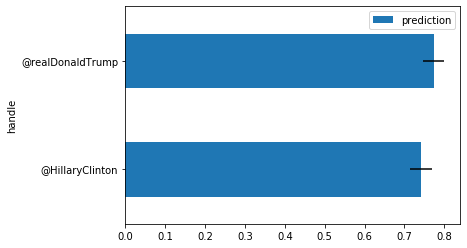

In [96]:
sentiment_pd.plot(x='handle', y='prediction', xerr='err', kind='barh');

In [98]:
#But let’s examine some “negative” tweets by Trump
best_model.\
    transform(tweets_df.withColumnRenamed('text', 'review')).\
    where(fn.col('handle') == '@realDonaldTrump').\
    where(fn.col('prediction') == 0).\
    select('review').\
    take(5)

[Row(review='Moderator: Hillary paid $225,000 by a Brazilian bank for a speech that called for “open borders.” That’s a quote! #Debate #BigLeagueTruth'),
 Row(review='Hillary is too weak to lead on border security-no solutions, no ideas, no credibility.She supported NAFTA, worst deal in US history. #Debate'),
 Row(review='UNBELIEVABLE!\nClinton campaign contractor caught in voter-fraud video is a felon who visited White House 342 times: https://t.co/qQdsMHAtkT'),
 Row(review='Obamacare premiums increasing 33% in Pennsylvania - a complete disaster. It must be repealed and replaced!… https://t.co/aDZEfcI7SM'),
 Row(review="'Dem Operative Who Oversaw Trump Rally Agitators Visited White House 342 Times' #DrainTheSwamp \nhttps://t.co/MO4SJaQMzo")]

In [99]:
#And Clinton
best_model.\
    transform(tweets_df.withColumnRenamed('text', 'review')).\
    where(fn.col('handle') == '@HillaryClinton').\
    where(fn.col('prediction') == 0).\
    select('review').\
    take(5)

[Row(review="We're going to make college debt-free for everyone in America. See how much you could save with Hillary's plan at… https://t.co/Fhzkubhpj7"),
 Row(review="Don't boo. Vote! https://t.co/tTgeqy51PU https://t.co/9un3FUVxoG"),
 Row(review='This Republican dad is struggling with the idea of his daughter growing up in a country led by Donald Trump. https://t.co/Tn3rQqJJKp'),
 Row(review='Hillary teamed up with @BernieSanders on a plan to make college debt-free for all Americans. https://t.co/sdWVzdxIrG'),
 Row(review="There are hundreds of thousands more @AmeriCorps applications than spots. Horrible! Let's expand it from 75,000 annual members to 250,000.")]